# Process the Hydrographic 17 and 18 Data into One Parquet

In [16]:
import geopandas as gpd
import pandas as pd

# Read both files (you probably meant different files for 17 and 18)
gdf18 = gpd.read_parquet("../flowline/WR_18_Flowline.parquet")
gdf17 = gpd.read_parquet("../flowline/WR_17_Flowline.parquet")  # <- likely what you meant

# Combine them
gdf_combined = pd.concat([gdf17, gdf18], ignore_index=True)

# Make sure it's a valid GeoDataFrame
gdf_combined = gpd.GeoDataFrame(gdf_combined, geometry="geometry", crs=gdf18.crs)

# Create alias
gdf_combined["feature_id"] = gdf_combined["COMID"]

# Save to GeoParquet
gdf_combined.to_parquet("../flowline/WR_1718_Flowline.parquet")


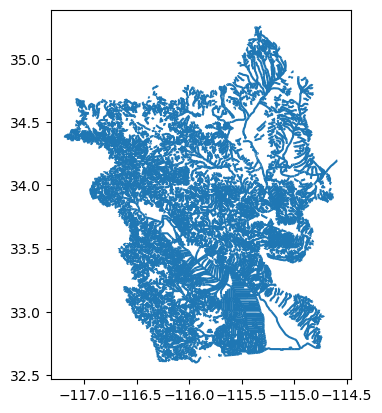

In [18]:
# test
import geopandas as gpd
gdf = gpd.read_parquet("../flowline/WR_1718_Flowline.parquet")
gdf_small = gdf[gdf["HUC4"] == "1810"]
gdf_small.plot();


## Create a map

/tmp/ipykernel_1267/2125719123.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", len(huc4_list))


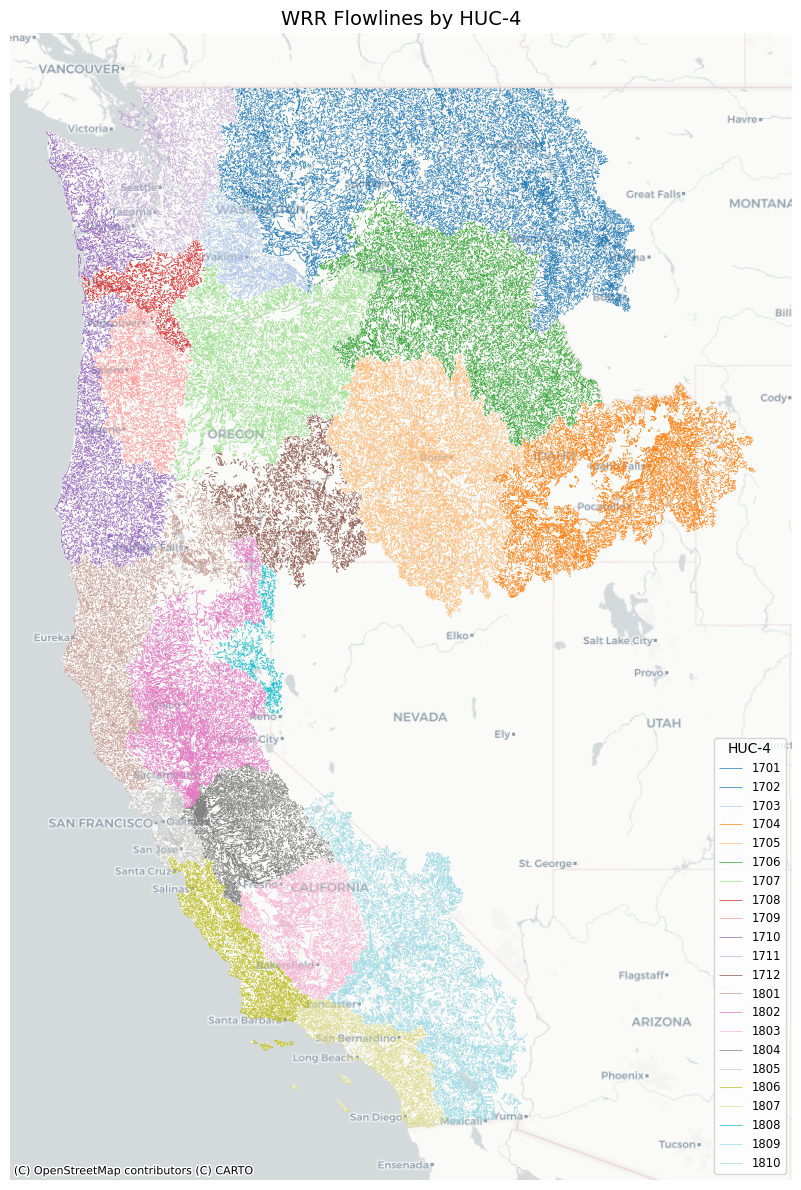

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Load the GeoParquet file
gdf = gpd.read_parquet("../flowline/WR_1718_Flowline.parquet")

# Set CRS if missing
if gdf.crs is None:
    gdf.set_crs("ESRI:102039", inplace=True)

# Clean up geometries
gdf = gdf[gdf.geometry.notnull() & gdf.geometry.is_valid]

# Reproject to Web Mercator
gdf = gdf.to_crs("EPSG:3857")

# Extract HUC-4 from REACHCODE
gdf["HUC4"] = gdf["REACHCODE"].str.slice(0, 4)

# Optional: sample for plotting efficiency
gdf_sampled = gdf.sample(frac=0.5, random_state=42)

# Get unique HUC-4s
huc4_list = sorted(gdf_sampled["HUC4"].unique())

# Create a colormap
cmap = cm.get_cmap("tab20", len(huc4_list))
color_map = {huc4: cmap(i) for i, huc4 in enumerate(huc4_list)}

# Plot
fig, ax = plt.subplots(figsize=(10, 12))

for huc4 in huc4_list:
    subset = gdf_sampled[gdf_sampled["HUC4"] == huc4]
    subset.plot(ax=ax, color=color_map[huc4], linewidth=0.5, label=huc4)

ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.CartoDB.Positron)

ax.set_title("WRR Flowlines by HUC-4", fontsize=14)
ax.axis("off")
ax.legend(title="HUC-4", loc="lower right", fontsize="small", title_fontsize="medium")
plt.tight_layout()

plt.savefig("../metadata/wr1718_map.png", dpi=300, bbox_inches="tight")
plt.show()


## Save the data frame of feature ids

In [2]:
import geopandas as gpd

gdf = gpd.read_parquet("../flowline/WR_1718_Flowline.parquet")

# Drop geometry if you don't need it
df = gdf.drop(columns="geometry")

df.to_parquet("../flowline/WR_1718_metadata.parquet")

## Test that it reads in ok

In [3]:
import pandas as pd

# Load the full parquet file
df = pd.read_parquet("../flowline/WR_1718_metadata.parquet")

# Filter where FTYPE is exactly "StreamRiver"
streamriver_df = df[df["FTYPE"] == "StreamRiver"]

# Extract COMIDs (aka feature_ids)
feature_ids = streamriver_df["feature_id"].unique()

len(feature_ids)

368105

## Summary 

The original shapefiles were processed into a geoparquet that is smaller in size. A parquet file with just the COMID id metadata is saved also as parquet file. These files will appear in the GCP bucket as follows.